# Importing libraries

In [ ]:
# import libraries needed
import pandas as pd 
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data import and pre-processing

In [ ]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = pd.read_excel('/content/drive/My Drive/jedha fundies/Data/100k lines_Data NYC restaurants.xlsx')

In [ ]:
dataset.head()

,ÔªøCAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,50070206,BLUE CAFE RESTAURANT & BAR,Queens,8263,BROADWAY,11373.0,7183960717,Spanish,2018-11-01 00:00:00,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140¬∫ F.,Y,14.0,NaN,NaN,07/20/2020,Pre-permit (Operational) / Initial Inspection,40.741920,-73.881125,404.0,25.0,27100.0,4037524.0,4.015180e+09,QN29
1,41713504,ISIS RESTAURANT,Bronx,739,ALLERTON AVENUE,10467.0,7183241054,Mexican,2019-09-10 00:00:00,Establishment Closed by DOHMH. Violations wer...,08A,Facility not vermin proof. Harborage or condit...,N,40.0,NaN,NaN,07/20/2020,Cycle Inspection / Initial Inspection,40.865466,-73.865700,211.0,15.0,33800.0,2053637.0,2.045100e+09,BX07
2,41674628,MANHATTAN PROPER,Manhattan,6,MURRAY STREET,10007.0,6465594445,American,02/26/2019,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Y,20.0,B,02/26/2019,07/20/2020,Cycle Inspection / Re-inspection,40.713222,-74.007622,101.0,1.0,2100.0,1001407.0,1.001240e+09,MN24
3,50012117,ROBERTA'S PIZZA & BAKERY,Brooklyn,261,MOORE STREET,11206.0,7184171118,Pizza,2019-01-05 00:00:00,No violations were recorded at the time of thi...,NaN,NaN,NaN,0.0,NaN,NaN,07/20/2020,Inter-Agency Task Force / Initial Inspection,40.704818,-73.934015,301.0,34.0,48500.0,3071483.0,3.031010e+09,BK78
4,41022489,LA CANOA,Queens,651,ONDERDONK AVENUE,11385.0,7184566011,"Latin (Cuban, Dominican, Puerto Rican, South &...",02/24/2020,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,24.0,NaN,NaN,07/20/2020,Cycle Inspection / Initial Inspection,40.704525,-73.908126,405.0,34.0,54700.0,4082889.0,4.034670e+09,QN20


In [ ]:
# cleaning the dataframe
# renaming columns
# deleting useless columns

# removing rows where ACTION = Establishment re-opened by DOHMH as they do not have a valid grade as per data documentation (grade of PREVIOUS inspection)
dataset = dataset.drop(dataset[(dataset['ACTION'] == 'Establishment re-opened by DOHMH')].index)

dataset = dataset.rename(
    columns={
        "ÔªøCAMIS": "Restaurant ID",
        "DBA": "Restaurant Name",
        "CUISINE DESCRIPTION": "Cuisine"
            })

dataset = dataset.drop(["BUILDING", "PHONE", "Community Board", "Council District", "Census Tract", "BIN", "BBL", "NTA","Restaurant Name","Restaurant ID","STREET","ACTION","VIOLATION DESCRIPTION","INSPECTION TYPE","GRADE DATE","RECORD DATE","Latitude","Longitude", "ZIPCODE","INSPECTION DATE","CRITICAL FLAG","RECORD DATE"], axis=1)

In [ ]:
dataset.head(15)

,BORO,Cuisine,VIOLATION CODE,SCORE,GRADE
0,Queens,Spanish,02B,14.0,NaN
1,Bronx,Mexican,08A,40.0,NaN
2,Manhattan,American,04L,20.0,B
3,Brooklyn,Pizza,NaN,0.0,NaN
4,Queens,"Latin (Cuban, Dominican, Puerto Rican, South &...",08A,24.0,NaN
5,Manhattan,Japanese,08A,11.0,A
6,Staten Island,Vietnamese/Cambodian/Malaysia,10F,8.0,A
7,Bronx,Spanish,10B,10.0,A
8,Queens,Korean,06C,32.0,NaN
9,Manhattan,Italian,04L,27.0,NaN


In [ ]:
dataset.isnull().sum()

BORO                  0
Cuisine               0
VIOLATION CODE     2173
SCORE              6482
GRADE             74175
dtype: int64

In [ ]:
# removing rows with no score or grade
dataset = dataset.dropna(subset=['SCORE','GRADE'])

# checking
dataset.isnull().sum()

BORO                0
Cuisine             0
VIOLATION CODE    262
SCORE               0
GRADE               0
dtype: int64

## Dummy-fying borough values

In [ ]:
# turn qualitative values into quantitative
# starting with boro
dummies_boro = pd.get_dummies(dataset['BORO'], drop_first=True)
dummies_boro.head()

,Bronx,Brooklyn,Manhattan,Queens,Staten Island
2,0,0,1,0,0
5,0,0,1,0,0
6,0,0,0,0,1
7,1,0,0,0,0
10,0,0,1,0,0


In [ ]:
dataset = dataset.merge(dummies_boro, left_index=True, right_index=True)
dataset.head()

,BORO,Cuisine,VIOLATION CODE,SCORE,GRADE,Bronx,Brooklyn,Manhattan,Queens,Staten Island
2,Manhattan,American,04L,20.0,B,0,0,1,0,0
5,Manhattan,Japanese,08A,11.0,A,0,0,1,0,0
6,Staten Island,Vietnamese/Cambodian/Malaysia,10F,8.0,A,0,0,0,0,1
7,Bronx,Spanish,10B,10.0,A,1,0,0,0,0
10,Manhattan,Seafood,10B,13.0,A,0,0,1,0,0


## Merging cuisine types for easier data analysis
We have 84 different cuisine types. It will be easier to merge them into categories to understand the data and see which features have influence in our models.
We will group cuisine types by continent.

In [ ]:
dataset.Cuisine.nunique()

84

In [ ]:
dataset.Cuisine.unique()

array(['American', 'Japanese', 'Vietnamese/Cambodian/Malaysia', 'Spanish',
       'Seafood', 'Donuts', 'Indian', 'Delicatessen', 'Chicken', 'French',
       'Bakery', 'Chinese', 'Caribbean', 'Turkish',
       'Bottled beverages, including water, sodas, juices, etc.', 'Thai',
       'Hamburgers', 'Jewish/Kosher', 'Ice Cream, Gelato, Yogurt, Ices',
       'Hotdogs', 'Vegetarian', 'Pizza', 'Greek', 'Caf√©/Coffee/Tea',
       'Steak', 'Armenian', 'African', 'Tex-Mex', 'Filipino',
       'Juice, Smoothies, Fruit Salads', 'Mexican', 'Pizza/Italian',
       'Korean', 'Asian',
       'Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
       'Italian', 'Soul Food', 'Russian', 'Brazilian', 'Mediterranean',
       'Chinese/Cuban', 'Bagels/Pretzels', 'Continental', 'Peruvian',
       'Bangladeshi', 'Eastern European',
       'Sandwiches/Salads/Mixed Buffet', 'English', 'Other', 'Irish',
       'Ethiopian', 'Hawaiian', 'Sandwiches', 'Salads', 'Middle Eastern',
       'Moroccan', 'B

In [ ]:
dataset['Cuisine'] = dataset['Cuisine'].replace(['Iranian','Middle Eastern','Indonesian','Bangladeshi','Afghan','Indian','Turkish','Japanese','Vietnamese/Cambodian/Malaysia','Korean','Asian','Filipino','Chinese/Japanese','Chinese','Thai'],'Asia')
dataset['Cuisine'] = dataset['Cuisine'].replace(['Spanish','Italian','French','English','Eastern European','Mediterranean','Greek','Russian','German','Irish','Polish','Portuguese','Czech','Basque','Scandinavian'],'Europe')
dataset['Cuisine'] = dataset['Cuisine'].replace(['American','Donuts','Caribbean','Tex-Mex','Mexican','Latin (Cuban, Dominican, Puerto Rican, South & Central American)','Brazilian','Chinese/Cuban','Soul Food','Peruvian','Bagels/Pretzels','Hawaiian','Barbecue','Southwestern','Cajun','Creole/Cajun','Californian','Chilean'], 'Americas')
dataset['Cuisine'] = dataset['Cuisine'].replace(['Ethiopian','Egyptian','Moroccan'],'Africa')
dataset['Cuisine'] = np.where(dataset['Cuisine'].isin(['Asia','Africa','Americas','Europe']), dataset['Cuisine'], 'Others')
print(dataset.Cuisine.unique())
print(dataset.Cuisine.nunique())

['Americas' 'Asia' 'Europe' 'Others' 'Africa']
5


## Dummy-fying cuisine and violation codes

In [ ]:
# same thing with cuisine and violation code
dummies_cuisine = pd.get_dummies(dataset['Cuisine'], drop_first=True)
dataset = dataset.merge(dummies_cuisine, left_index=True, right_index=True)
dummies_code = pd.get_dummies(dataset['VIOLATION CODE'], drop_first=True)
dataset = dataset.merge(dummies_code, left_index=True, right_index=True)

In [ ]:
# creating a second dataframe where we remove GRADE as we first need only numeric values for the multivariate linear regression
dataset_num = dataset.drop(['BORO','Cuisine','VIOLATION CODE','GRADE'], axis=1)

In [ ]:
dataset_num.head(5)

,SCORE,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Americas,Asia,Europe,Others,02B,02C,02D,02E,02F,02G,02H,02I,03A,03B,03C,03D,03E,03G,04A,04B,04C,04D,04E,04F,04G,04H,04J,04K,04L,04M,04N,04O,05A,05B,05C,05D,05E,05F,05H,06A,06B,06C,06D,06E,06F,06G,06H,06I,07A,08A,08B,08C,09A,09B,09C,10A,10B,10C,10D,10E,10F,10G,10H,10I,10J,22F,22G
2,20.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,11.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,8.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,10.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
10,13.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


# Linear regression multi-variable

In [ ]:
# defining X and y, y being the SCORE and X being all other columns *not SCORE*
y = dataset_num["SCORE"]
X = dataset_num.drop("SCORE", axis=1)

In [ ]:
dataset_num.SCORE = dataset_num.SCORE.astype(int)
# removing -1 -0 scores
dataset_num= dataset_num.drop(dataset_num[(dataset_num['SCORE'] == -1)].index)
dataset_num= dataset_num.drop(dataset_num[(dataset_num['SCORE'] == -0)].index)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

from sklearn.linear_model import LinearRegression
reg = LinearRegression()

reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print("Score Train:",reg.score (X_train, y_train))
print("Score Test:",reg.score (X_test, y_test))

Score Train: 0.10298213096324194
Score Test: -2.740499180745868e+19


In [ ]:
predictions = reg.predict(X_test)
print(predictions[0:50])

[13.33684233 11.04697865 10.47094175 10.90479291 11.15269267 15.15407092
 12.29498589 11.86578359  9.5697961  16.32370904 16.1716541  12.48808753
 16.47699669 14.73899062 11.30911561 16.41994601 11.79254551  9.40520954
 10.47094175 11.70119702 12.88253512 12.24762568  9.5697961  15.01331489
 12.71270164 15.33260798 15.57178667  9.88863944 11.70119702 11.11532825
 11.72419591 16.10315949 11.76954662 14.09870488 10.37292675 20.33026225
 16.00488185 11.04697865 10.41206921  9.95698904 12.4884376  15.65768941
 15.09702024 13.34776697 10.37470479 16.98061518 11.86578359 10.30635519
 12.95088472  9.95698904]


In [ ]:
# comparing predictions vs y_test
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
print(predictions_df.head(10))

        Actual  Predicted
132273    13.0  13.336842
34021     13.0  11.046979
76624     10.0  10.470942
32034     12.0  10.904793
21302     13.0  11.152693
94288     13.0  15.154071
40026      6.0  12.294986
118098    12.0  11.865784
87551      8.0   9.569796
96644     35.0  16.323709


Text(0.5, 1.0, 'Actual scores vs model predictions')

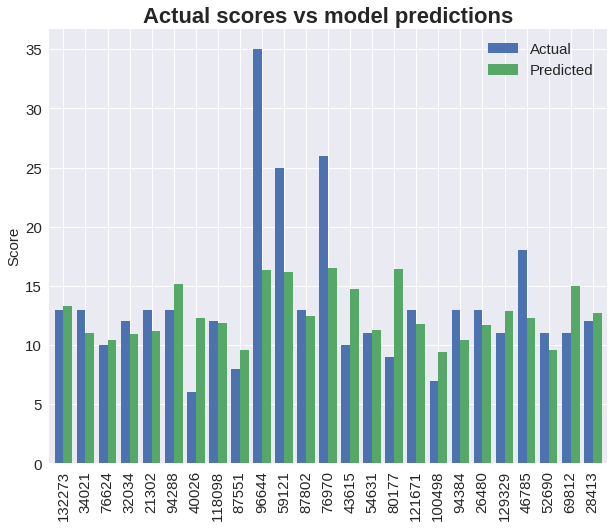

In [ ]:
# plotting actual vs predicted values
pred_plot = predictions_df.head(25)
pred_plot.plot(kind='bar',figsize=(10,8), fontsize=15, width=0.8)
plt.ylabel('Score', fontsize=15)
plt.legend(fontsize= 15)
plt.title('Actual scores vs model predictions', fontsize=22, fontweight='bold')

In [ ]:
coef_reg = pd.DataFrame({"Features":dataset_num.columns[1:],
                                    "Coef": reg.coef_})

# positive impact of feature on SCORE (i.e. SCORE gets larger -> worse)
coef_reg.nlargest(10, 'Coef')

,Features,Coef
42,05F,0.606763
39,05C,0.566875
23,04A,0.548926
40,05D,0.489203
41,05E,0.422082
43,05H,0.413256
35,04N,0.384426
54,08A,0.335225
34,04M,0.331856
50,06G,0.324047


In [ ]:
coef_reg['abs_coef'] = coef_reg['Coef'].abs()
coef_reg.sort_values('abs_coef', ascending=True)[['Features', 'Coef']]

,Features,Coef
24,04B,4.121122e-05
20,03D,3.038642e-02
12,02E,4.087849e-02
22,03G,4.318485e-02
29,04G,4.486461e-02
...,...,...
14,02G,2.946650e+00
33,04L,3.200873e+00
65,10F,3.245020e+00
54,08A,3.989468e+00


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()
rfreg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
print("Score train:", rfreg.score(X_train, y_train))
print("Score test:", rfreg.score(X_test, y_test))

Score train: 0.12578214168411572
Score test: 0.06873988986729096


# Decision tree modeling

## First tree

In [ ]:
# we take our 'initial' dataset and drop SCORE
dataset_categ = dataset.drop(['SCORE'], axis=1)

In [ ]:
# dropping non dummies columns
dataset_categ = dataset_categ.drop(['BORO','Cuisine','VIOLATION CODE'], axis=1)
dataset_categ.head(5)

,GRADE,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Americas,Asia,Europe,Others,02B,02C,02D,02E,02F,02G,02H,02I,03A,03B,03C,03D,03E,03G,04A,04B,04C,04D,04E,04F,04G,04H,04J,04K,04L,04M,04N,04O,05A,05B,05C,05D,05E,05F,05H,06A,06B,06C,06D,06E,06F,06G,06H,06I,07A,08A,08B,08C,09A,09B,09C,10A,10B,10C,10D,10E,10F,10G,10H,10I,10J,22F,22G
2,B,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,A,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,A,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,A,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
10,A,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
# removing grades that aren't A/B/C (the other letter grades mean that the grade is pending and thus aren't useful here)
dataset_categ = dataset_categ.drop(dataset_categ[(dataset_categ['GRADE'] == 'N')].index)
dataset_categ = dataset_categ.drop(dataset_categ[(dataset_categ['GRADE'] == 'Z')].index)
dataset_categ = dataset_categ.drop(dataset_categ[(dataset_categ['GRADE'] == 'P')].index)
dataset_categ = dataset_categ.drop(dataset_categ[(dataset_categ['GRADE'] == 'G')].index)
dataset_categ.GRADE.unique()

array(['B', 'A', 'C'], dtype=object)

In [ ]:
# defining X and y, y being the GRADE and X being all other columns *not GRADE*
y = dataset_categ["GRADE"]
X = dataset_categ.drop("GRADE", axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(class_weight='balanced')
classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
# evaluating model scores
print("Score train:", classifier.score(X_train, y_train))
print("Score test:", classifier.score(X_test, y_test))

Score train: 0.5592925235739282
Score test: 0.5417499827621871


In [ ]:
pred_tree = classifier.predict(X_test)
# comparing predictions vs y_test
pred_tree_df = pd.DataFrame({'Actual': y_test, 'Predicted': pred_tree})
pred_tree_df.head(75)

,Actual,Predicted
29624,A,C
1384,B,B
41690,B,B
132505,A,B
138125,A,B
...,...,...
103538,A,A
52663,A,A
100084,A,A
65130,A,B


In [ ]:
# split of predictions by categories
print(np.unique(pred_tree, return_counts=True))

(array(['A', 'B', 'C'], dtype=object), array([7444, 4142, 2917]))


In [ ]:
# putting feature importance in a dataframe
feature_importance = pd.DataFrame({"Features":dataset_categ.columns[1:],
                                    "Value": classifier.feature_importances_})

# getting the top 10
feature_importance.nlargest(10, 'Value')

,Features,Value
65,10F,0.220306
6,Asia,0.048131
2,Manhattan,0.040017
1,Brooklyn,0.037853
47,06D,0.037094
3,Queens,0.036690
0,Bronx,0.035237
61,10B,0.032075
59,09C,0.031160
46,06C,0.027959


# Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print("Score train:",forest.score(X_train, y_train))
print("Score test:",forest.score(X_test, y_test))
print("Estimateur naïf score:", forest.score(X_test, np.array(['A'] * len(y_test))))

Score train: 0.8280956403316727
Score test: 0.8292077501206647
Estimateur naïf score: 0.9947597048886437


In [ ]:
pred_forest = forest.predict(X_test)
# comparing predictions vs y_test
pred_forest_df = pd.DataFrame({'Actual': y_test, 'Predicted': pred_forest})
pred_forest_df.head(75)

,Actual,Predicted
29624,A,A
1384,B,A
41690,B,A
132505,A,A
138125,A,A
...,...,...
103538,A,A
52663,A,A
100084,A,A
65130,A,A


In [ ]:
# split predictions
print("predictions:", np.unique(pred_forest, return_counts=True))

predictions: (array(['A', 'B', 'C'], dtype=object), array([14427,    49,    27]))


In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
labels = ['A', 'B', 'C']
cm = confusion_matrix(y_test, forest.predict(X_test), labels)
cm

array([[12000,    26,    14],
       [ 1817,    17,     4],
       [  610,     6,     9]])

[Text(0, 0.5, 'A'), Text(0, 1.5, 'B'), Text(0, 2.5, 'C')]

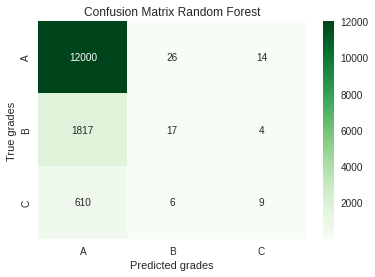

In [ ]:
ax = plt.subplot()
sb.heatmap(cm, annot=True, fmt=".0f", cmap='Greens', ax = ax)
ax.set_xlabel('Predicted grades')
ax.set_ylabel('True grades')
ax.set_title('Confusion Matrix Random Forest')
ax.xaxis.set_ticklabels(['A', 'B', 'C']); ax.yaxis.set_ticklabels(['A', 'B', 'C'])

In [ ]:
# putting feature importance in a dataframe
feature_importance_forest = pd.DataFrame({"Features":dataset_categ.columns[1:],
                                    "Value": forest.feature_importances_})

# getting the top 10
feature_importance_forest.nlargest(10, 'Value')

,Features,Value
65,10F,0.124927
34,04M,0.047946
35,04N,0.047905
14,02G,0.043018
54,08A,0.042498
33,04L,0.041253
6,Asia,0.037750
23,04A,0.036104
2,Manhattan,0.032499
1,Brooklyn,0.031189


# Naive classification

In [ ]:
from sklearn.naive_bayes import GaussianNB
naiveb = GaussianNB()
naiveb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
print("Score train:",naiveb.score(X_train, y_train))
print("Score test:",naiveb.score(X_test, y_test))

Score train: 0.7894292264993363
Score test: 0.7928704405984969


In [ ]:
pred_naiveb = naiveb.predict(X_test)
pred_naiveb_df = pd.DataFrame({'Actual': y_test, 'Predicted': pred_naiveb})
pred_naiveb_df.head(75)

,Actual,Predicted
29624,A,A
1384,B,A
41690,B,A
132505,A,B
138125,A,A
...,...,...
103538,A,A
52663,A,A
100084,A,A
65130,A,A


# Just for fun: predicting GRADE based on SCORE
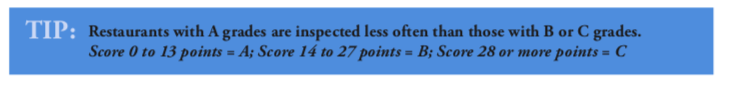

In [ ]:
dataset = dataset.drop(dataset[(dataset['GRADE'] == 'N')].index)
dataset = dataset.drop(dataset[(dataset['GRADE'] == 'Z')].index)
dataset = dataset.drop(dataset[(dataset['GRADE'] == 'P')].index)
dataset = dataset.drop(dataset[(dataset['GRADE'] == 'G')].index)
dataset.GRADE.unique()

array(['B', 'A', 'C'], dtype=object)

In [ ]:
X_fun = dataset["SCORE"]
y_fun = dataset["GRADE"]

In [ ]:
# casting SCORE as integer
# removing -1 and 0 scores (irrelevant)
dataset.SCORE = dataset.SCORE.astype(int)
dataset= dataset.drop(dataset[(dataset['SCORE'] == -1)].index)
dataset= dataset.drop(dataset[(dataset['SCORE'] == -0)].index)

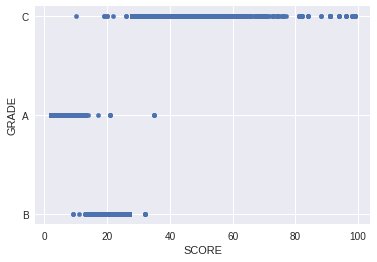

In [ ]:
dataset.plot(kind='scatter', x='SCORE', y='GRADE')

The scatter plot shows the relation between SCORE <> GRADE.

In [ ]:
from sklearn.model_selection import train_test_split
X_fun_train, X_fun_test, y_fun_train, y_fun_test = train_test_split(X_fun, y_fun, test_size=0.2, random_state=0)

In [ ]:
X_fun_train = X_fun_train.values.reshape(-1,1)
X_fun_test = X_fun_test.values.reshape(-1,1)

## log regression

In [ ]:
from sklearn.linear_model import LogisticRegression
log_fun = LogisticRegression()
log_fun.fit(X_fun_train, y_fun_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print("Score train:", log_fun.score(X_fun_train, y_fun_train))

Score train: 0.990415280387526


In [ ]:
print("Score test:", log_fun.score(X_fun_test, y_fun_test))

Score test: 0.9910363373095221


In [ ]:
pred_log = log_fun.predict(X_fun_test)
print(np.unique(pred_log, return_counts=True))

(array(['A', 'B', 'C'], dtype=object), array([12134,  1782,   587]))


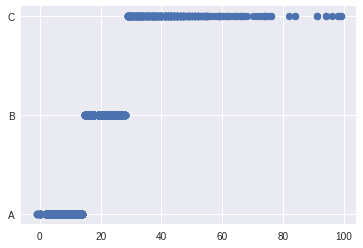

In [ ]:
plt.scatter(X_fun_test, pred_log)

### confusion matrix reverse engineering log reg

[[12039     0     1]
 [   90  1748     0]
 [    5    34   586]]


[Text(0, 0.5, 'A'), Text(0, 1.5, 'B'), Text(0, 2.5, 'C')]

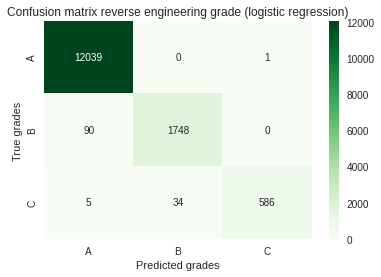

In [ ]:
# confusion matrix
cm_log = confusion_matrix(y_fun_test, pred_log)
cm_log
print(cm_log)

ax = plt.subplot()
sb.heatmap(cm_log, annot=True, fmt=".0f", cmap='Greens', ax = ax)
ax.set_xlabel('Predicted grades')
ax.set_ylabel('True grades')
ax.set_title('Confusion matrix reverse engineering grade (logistic regression)')
ax.xaxis.set_ticklabels(['A', 'B', 'C']); ax.yaxis.set_ticklabels(['A', 'B', 'C'])

# Conclusion

In [ ]:
Score - linear regression: 

SyntaxError: ignored